In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
salaries_df = pd.read_csv('NBA_SALARIES.csv')
stats_df = pd.read_csv('NBA_STATS.csv')

In [12]:
print("Salary data shape:", salaries_df.shape)
print("Stats data shape:", stats_df.shape)

Salary data shape: (894, 11)
Stats data shape: (1684, 73)


In [13]:
print("\nSalary data head:")
print(salaries_df.head())
print("\nStats data head:")
print(stats_df.head())


Salary data head:
              Player    2020-21    2021-22    2022-23    2023-24    2024-25  \
0      Stephen Curry  43.006362  45.780966  48.070014  51.915615  55.761216   
1         Chris Paul  41.358814  30.800000  28.400000  30.800000  30.000000   
2  Russell Westbrook  41.358814  44.211146  47.080179   3.835738   4.027525   
3       James Harden  41.254920  44.310840  33.000000  35.640000  -1.000000   
4          John Wall  41.254920  44.310840  47.345760   6.802950  -1.000000   

     2025-26  2026-27  2027-28  2028-29  Guaranteed  
0  59.606817     -1.0     -1.0     -1.0  167.283648  
1  -1.000000     -1.0     -1.0     -1.0   15.800000  
2  -1.000000     -1.0     -1.0     -1.0    7.863263  
3  -1.000000     -1.0     -1.0     -1.0   35.640000  
4  -1.000000     -1.0     -1.0     -1.0    6.802950  

Stats data head:
             Player Pos  Age   Tm   G  GS  MP_per_game  FG_per_game  \
0  Precious Achiuwa   C   23  TOR  55  12         20.7          3.6   
1      Steven Adams   

In [15]:
def clean_salary_data(df):
    salary_columns = df.select_dtypes(include=[np.number]).columns
    df['avg_salary'] = df[salary_columns].mean(axis=1)
    return df[['Player', 'avg_salary']]

In [17]:
def clean_stats_data(df):
    relevant_features = [
        'Player', 'Age', 'MP_per_game', 'PTS_per_game', 'AST_per_game',
        'TRB_per_game', 'STL_per_game', 'BLK_per_game', 'FG%_per_game',
        '3P%_per_game', 'FT%_per_game', 'PER_advanced', 'WS_advanced'
    ]
    df = df[relevant_features]
    percentage_columns = [col for col in df.columns if '%' in col]
    for col in percentage_columns:
        df[col] = pd.to_numeric(df[col].astype(str).str.rstrip('%'), errors='coerce') / 100
    
    return df

In [18]:
clean_salaries = clean_salary_data(salaries_df)
clean_stats = clean_stats_data(stats_df)

/var/folders/87/k2ljqtb50cq9d45rr88yd6nm0000gn/T/ipykernel_54252/3170625696.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col].astype(str).str.rstrip('%'), errors='coerce') / 100
/var/folders/87/k2ljqtb50cq9d45rr88yd6nm0000gn/T/ipykernel_54252/3170625696.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col].astype(str).str.rstrip('%'), errors='coerce') / 100
/var/folders/87/k2ljqtb50cq9d45rr88yd6nm0000gn/T/ipykernel_54252/3170625696.py:10: Set

In [19]:
merged_df = pd.merge(clean_stats, clean_salaries, on='Player', how='inner')


In [20]:
X = merged_df.drop(['Player', 'avg_salary'], axis=1)
y = merged_df['avg_salary']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [24]:
train_score = model.score(X_train_scaled, y_train)
test_score = model.score(X_test_scaled, y_test)

In [25]:
print(f"Training R² score: {train_score:.3f}")
print(f"Testing R² score: {test_score:.3f}")

Training R² score: 0.953
Testing R² score: 0.750


In [26]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [27]:
print("\nFeature Importance:")
print(feature_importance)


Feature Importance:
         feature  importance
2   PTS_per_game    0.652054
1    MP_per_game    0.076894
11   WS_advanced    0.044522
0            Age    0.040632
3   AST_per_game    0.039854
10  PER_advanced    0.031262
4   TRB_per_game    0.024897
9   FT%_per_game    0.022984
7   FG%_per_game    0.018627
5   STL_per_game    0.017829
8   3P%_per_game    0.017354
6   BLK_per_game    0.013090


In [28]:
def predict_salary(stats_dict):
    """
    Predict salary based on input statistics.
    
    Parameters:
    stats_dict (dict): Dictionary containing player statistics
        Required keys: 'Age', 'MP_per_game', 'PTS_per_game', 'AST_per_game',
                      'TRB_per_game', 'STL_per_game', 'BLK_per_game',
                      'FG%_per_game', '3P%_per_game', 'FT%_per_game',
                      'PER_advanced', 'WS_advanced'
    
    Returns:
    float: Predicted salary
    """

    stats_df = pd.DataFrame([stats_dict])
    
    required_features = X.columns.tolist()
    missing_features = set(required_features) - set(stats_df.columns)
    if missing_features:
        raise ValueError(f"Missing required features: {missing_features}")
    
    scaled_stats = scaler.transform(stats_df[required_features])
    
    predicted_salary = model.predict(scaled_stats)[0]
    
    return predicted_salary

In [32]:
example_player_stats = {
    'Age': 25,
    'MP_per_game': 30,
    'PTS_per_game': 20,
    'AST_per_game': 5,
    'TRB_per_game': 5,
    'STL_per_game': 1,
    'BLK_per_game': 0.5,
    'FG%_per_game': 0.45,
    '3P%_per_game': 0.35,
    'FT%_per_game': 0.80,
    'PER_advanced': 15,
    'WS_advanced': 5
}


Example Prediction:
Predicted salary: $21.61


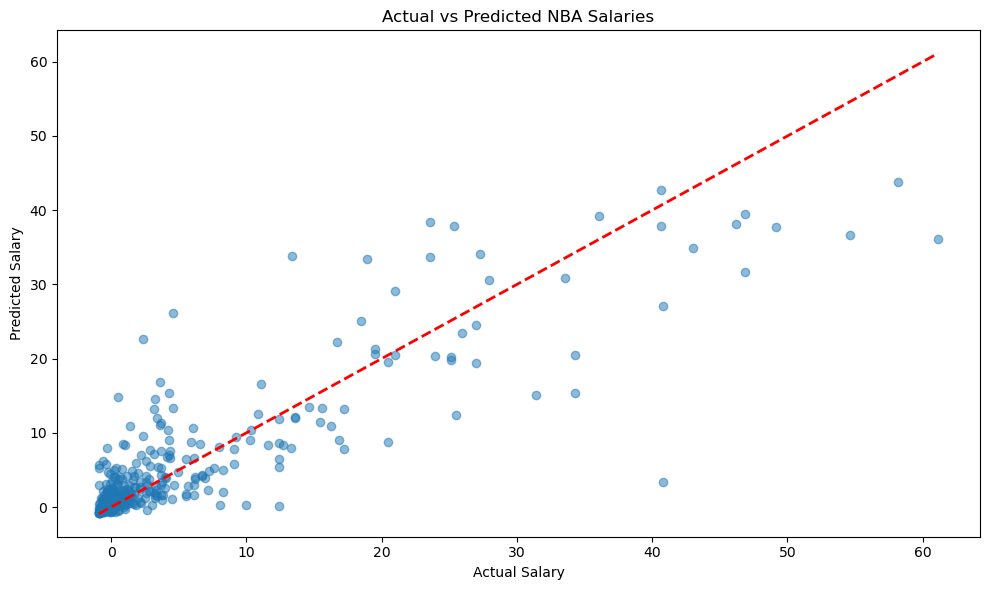

In [33]:
predicted_salary = predict_salary(example_player_stats)
print(f"\nExample Prediction:")
print(f"Predicted salary: ${predicted_salary:,.2f}")

y_pred = model.predict(X_test_scaled)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title('Actual vs Predicted NBA Salaries')
plt.tight_layout()
plt.show()